#Detection of Potential Labour Trafficking from Online Job Advertisements

####Dataset: https://docs.google.com/spreadsheets/d/1nmVxw7iXkJccaWHDy8DmxPO3BFkoWXQj/edit?usp=sharing&ouid=114382185693817861245&rtpof=true&sd=true

##1. Web Scraping (Extract > Transform > Load) - Data Collection

In [1]:
#Mount data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import relevant packages

#Web Scrapping
import requests #allow to send HTTP requests 
from bs4 import BeautifulSoup #allow parsing HTML and XML documents to extract data from HTML

#Data Manipulation
import pandas, xgboost
import pandas as pd #for data manipulation
import numpy as np #arrays
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import collections
from collections import Counter

#Text/Data Pre-Processing
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install contractions
import contractions
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import spacy
from sklearn.feature_extraction.text import CountVectorizer

#Model building
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Performance evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 284 kB 5.3 MB/s 
     |████████████████████████████████| 321 kB 44.6 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=e31df81ba2511b3731772da66a030c0bcfc202a3d7051b34cbc2cad5b1536aff
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [3]:
#To check whether the website is extractable

#Labourer
def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    return r.status_code

print(extract(0)) #first page


200


In [4]:
#To extract job title

def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup
  
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container')
    for i in divs:
        title = i.find('h2').text.strip() #find the title but remove wide spaces
        title2 = title.replace('new','') #remove the word 'new'
        print(title2)
    return

data = extract(0)
transform(data)

Labourer
Warehouse Operatives
Labourer
Labourer
Labourer
Labourer- Ecclesden Park
CSCS Labourer
Labourer
Yardsperson /Labourer
Labourer
Farm Worker
CSCS Labourer
Construction Labourer
Warehouse Operative
Warehouse Workers


In [5]:
#To extract job title, salary and summary

def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup
  
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container')
    for i in divs:
        title = i.find('h2').text.strip() #find the title but remove wide spaces
        title2 = title.replace('new','') #remove the word 'new'
        try:
          salary = i.find('div', class_ = 'salary-snippet').text.strip()
        except:
          salary = ''
        summary = i.find('div', class_ = 'job-snippet').text.strip()

        job = {
             'title': title2,
             'salary': salary,
             'summary': summary
        }

        joblist.append(job)
    return

joblist = []
data = extract(0)
transform(data)
print(joblist)



[{'title': 'Labourer', 'salary': '£22,183 a year', 'summary': 'To be responsible for providing general support and assistance to skilled and specialist operatives within Road Works.'}, {'title': 'Warehouse Operatives', 'salary': '£34,000 a year', 'summary': 'Do you want to earn a basic salary of £24,000 plus one days overtime a week is £34,000 per annum.\nCan you work a rotating shift pattern of 4 days on 4 days off,…'}, {'title': 'Labourer', 'salary': '', 'summary': 'Reporting to the Site Manager, to ensure that all labouring tasks are completed to the highest standard and within the required timescales.'}, {'title': 'Labourer', 'salary': '', 'summary': 'Working closely with the Senior Labourer and the Facilities Administrators, you will ensure that the property/premises are maintained to a high standard and to…'}, {'title': 'Labourer', 'salary': '£14 an hour', 'summary': 'You will be assisting Electricians and Electrical Improvers on site, you will need your CSCS card.'}, {'title': '

In [6]:
#Labourer
#To extract job title, salary and summary

def extract(page):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url = f'https://uk.indeed.com/jobs?q=labourer&l=United+Kingdom&start={page}' #website link
    r = requests.get(url, headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup
  
def transform(soup):
    divs = soup.find_all('div', class_ = 'slider_container')
    for i in divs:
        title = i.find('h2').text.strip() #find the title but remove wide spaces
        title2 = title.replace('new','') #remove the word 'new'
        try:
          salary = i.find('div', class_ = 'salary-snippet').text.strip()
        except:
          salary = ''
        summary = i.find('div', class_ = 'job-snippet').text.strip()

        job = {
             'title': title2,
             'salary': salary,
             'summary': summary
        }

        joblist.append(job)
    return

joblist = []
data = extract(0)
transform(data)

for x in range(0,900,10):
  print(f'Getting page, {x}')
  data = extract(0)
  transform(data)

print(joblist)

##Domestic Cleaner/Worker
#To extract job title, salary and summary

def extract2(page):
    headers2 = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.1 Safari/605.1.15'}
    url2 = f'https://uk.indeed.com/jobs?q=domestic+cleaner&l=United+Kingdom&start={page}' #website link
    r2 = requests.get(url2, headers2)
    soup2 = BeautifulSoup(r2.content, 'html.parser')
    return soup2
  
def transform2(soup):
    divs2 = soup.find_all('div', class_ = 'slider_container')
    for i in divs2:
        title1_2 = i.find('h2').text.strip() #find the title but remove wide spaces
        title2_2 = title1_2.replace('new','') #remove the word 'new'
        try:
          salary2 = i.find('div', class_ = 'salary-snippet').text.strip()
        except:
          salary2 = ''
        summary2 = i.find('div', class_ = 'job-snippet').text.strip()

        job2 = {
             'title': title2_2,
             'salary': salary2,
             'summary': summary2
        }

        joblist2.append(job2)
    return


joblist2 = []
data2 = extract2(0)
transform2(data2)
print(joblist2)

for x in range(0,900,10):
  print(f'Getting page, {x}')
  data2 = extract2(0)
  transform2(data2)

print(joblist2)


Getting page, 0
Getting page, 10
Getting page, 20
Getting page, 30
Getting page, 40
Getting page, 50
Getting page, 60
Getting page, 70
Getting page, 80
Getting page, 90
Getting page, 100
Getting page, 110
Getting page, 120
Getting page, 130
Getting page, 140
Getting page, 150
Getting page, 160
Getting page, 170
Getting page, 180
Getting page, 190
Getting page, 200
Getting page, 210
Getting page, 220
Getting page, 230
Getting page, 240
Getting page, 250
Getting page, 260
Getting page, 270
Getting page, 280
Getting page, 290
Getting page, 300
Getting page, 310
Getting page, 320
Getting page, 330
Getting page, 340
Getting page, 350
Getting page, 360
Getting page, 370
Getting page, 380
Getting page, 390
Getting page, 400
Getting page, 410
Getting page, 420
Getting page, 430
Getting page, 440
Getting page, 450
Getting page, 460
Getting page, 470
Getting page, 480
Getting page, 490
Getting page, 500
Getting page, 510
Getting page, 520
Getting page, 530
Getting page, 540
Getting page, 550
Get

In [7]:
#Combine both text data of labourers and domestic workers

joblist.extend(joblist2)

df = pd.DataFrame(joblist)

display(df)

df.to_excel('jobs.xlsx')

,title,salary,summary
0,Labourer,"£22,183 a year",To be responsible for providing general suppor...
1,Warehouse Operatives,"£34,000 a year",Our client is recruiting a number of Warehouse...
2,Labourer,,"Within the Construction environment, think abo..."
3,Labourer,,It is the only Hollywood owned studio of its c...
4,Labourer,£14 an hour,We are looking for 2 labourers to start work o...
...,...,...,...
2665,Domestic Cleaner,£8.91 an hour,Carry out all cleaning duties as directed by t...
2666,Cleaners / Domestic Assistants,£15.40 an hour,Saturday overtime is available and the hourly ...
2667,House Cleaner,£10 - £12 an hour,We are looking for experienced domestic cleane...
2668,Domestic Cleaner,£10.20 an hour,£10.20* per hour (including positive attendanc...


##2. Labelling the Text Features into Potential/Not Potential Labour Trafficking Based On Expertise & Related Works' Requirements

In [8]:
#Outcome of labelled text
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/CP2/jobs_final.xlsx')

In [9]:
#To check 5 rows of data
data.iloc[300:305,]

,title,salary2,salary,summary,target,justification
300,Shop Assistant / General Worker,13.57,13.570000,Serving customers and keeping areas clean and ...,Potential,Working experience or relevant skills is not r...
301,Labourer,14.00,14.000000,You will be assisting Electricians and Electri...,Not Potential,NaN
302,Domestic Cleaner,42644.00,17.084936,We are looking for experienced domestic cleane...,Potential,"Temporary, part-time or no contract job"
303,Domestic Cleaner,14846.00,5.947917,Our aim is to deliver outstanding care and sup...,Potential,Salary offered is below the UK labour law; Min...
304,Labourer,23625.00,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,"Expenses for tools, accommodation and transpor..."


In [10]:
#To include only relevant features (excluding justification)
data2 = data.drop(['justification','title','salary2'], axis=1)
data2.head()

,salary,summary,target
0,10.000000,Previous experience as a cleaner.\nDisposal of...,Not Potential
1,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential
2,10.000000,We cover you in our insurance.\nGet paid cash ...,Not Potential
3,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential
4,NaN,To carry out daily cleaning duties to required...,Not Potential


##3. Text Pre-Processing

In [11]:
#Shuffle data
train = shuffle(data2)

#Check count of missing values
print(" \nNumber of Missing Values : \n\n",train.isnull().sum()) 

#remove any missing values
train = train.dropna() 

#Check count of missing values again
print(" \nNumber of Missing Values : \n",train.isnull().sum()) 


 
Number of Missing Values : 

 salary     413
summary      0
target       0
dtype: int64
 
Number of Missing Values : 
 salary     0
summary    0
target     0
dtype: int64


In [12]:
#1. Lowercase
train["clean_summary"] = train["summary"].apply(lambda x: x.lower())
display(train.head())



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,salary,summary,target,clean_summary
2115,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,smarttech - buy an electrical item and pay it ...
1993,10.800000,If you have previous experience as a Cleaner A...,Not Potential,if you have previous experience as a cleaner a...
2002,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...
293,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...
891,17.109375,We are looking for experienced domestic cleane...,Potential,we are looking for experienced domestic cleane...


In [13]:
#2. Expand the contractions
train["clean_summary"] = train["clean_summary"].apply(lambda x: contractions.fix(x))
display(train.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,salary,summary,target,clean_summary
2115,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,smarttech - buy an electrical item and pay it ...
1993,10.800000,If you have previous experience as a Cleaner A...,Not Potential,if you have previous experience as a cleaner a...
2002,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...
293,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...
891,17.109375,We are looking for experienced domestic cleane...,Potential,we are looking for experienced domestic cleane...


In [14]:
#3. Removal of unnecessary characters or punctuations

#3.1 Remove URL in case there is any:

def remove_URL(summary):
    
    return re.sub(r"https?://\S+|www\.\S+", "", summary)

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_URL(x))

#3.2 Remove HTML tags:

def remove_html(summary):
  
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", summary)

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_html(x))

#3.3 Remove non-ASCI:

def remove_non_ascii(summary):
    
    return re.sub(r'[^\x00-\x7f]',r'', summary)

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_non_ascii(x))

#3.4 Remove punctuations:

def remove_punctuations(summary):
  
    return summary.translate(str.maketrans('', '', string.punctuation))

train["clean_summary"] = train["clean_summary"].apply(lambda x: remove_punctuations(x))

#3.5 Remove numbers

train["clean_summary"] = train["clean_summary"].str.replace('\d+', ' ')

#3.6 Replace \n with space

train["clean_summary"] = train["clean_summary"].replace("\n", " ")

display(train.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,salary,summary,target,clean_summary
2115,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,smarttech buy an electrical item and pay it o...
1993,10.800000,If you have previous experience as a Cleaner A...,Not Potential,if you have previous experience as a cleaner a...
2002,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...
293,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...
891,17.109375,We are looking for experienced domestic cleane...,Potential,we are looking for experienced domestic cleane...


In [15]:
#4. Lemmatization with stopword removal

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
train['lemmatized_stopword_summary']=train['clean_summary'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

#Group the summary according to the target variable
train_grouped=train[['target ','lemmatized_stopword_summary']].groupby(by='target ').agg(lambda x:' '.join(x))
train_grouped.head()


,lemmatized_stopword_summary
target,
Not Potential,previous experience cleaner apply immediate co...
Potential,smarttech buy electrical item pay salary ...


In [16]:
#5. Tokenization
train['tokenized_summary'] = train['lemmatized_stopword_summary'].apply(word_tokenize)
display(train.head())

,salary,summary,target,clean_summary,lemmatized_stopword_summary,tokenized_summary
2115,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,smarttech buy an electrical item and pay it o...,smarttech buy electrical item pay salary ...,"[smarttech, buy, electrical, item, pay, salary..."
1993,10.800000,If you have previous experience as a Cleaner A...,Not Potential,if you have previous experience as a cleaner a...,previous experience cleaner apply immediate co...,"[previous, experience, cleaner, apply, immedia..."
2002,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...,exciting opportunity arise facility directorat...,"[exciting, opportunity, arise, facility, direc..."
293,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...,exciting opportunity arise facility directorat...,"[exciting, opportunity, arise, facility, direc..."
891,17.109375,We are looking for experienced domestic cleane...,Potential,we are looking for experienced domestic cleane...,look experienced domestic cleaner want parttim...,"[look, experienced, domestic, cleaner, want, p..."


In [17]:
#Transform text data to count matrix
word_vectorizer = TfidfVectorizer(sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    max_df=0.5,
    max_features=30000) 

word_features = word_vectorizer.fit_transform(train['tokenized_summary'].str.join(' '))

word_features

word_features.A

word_vectorizer.get_feature_names()

token = pd.DataFrame.sparse.from_spmatrix(word_features, columns=word_vectorizer.get_feature_names(),index=train.index)

print(token)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


       ability  able  access  accordance  ...  worker  workload      year    yearly
2115  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.278194
1993  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
2002  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
293   0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
891   0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
...        ...   ...     ...         ...  ...     ...       ...       ...       ...
1266  0.238467   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
2220  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.303138  0.000000
1821  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
1047  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0.000000
1587  0.000000   0.0     0.0         0.0  ...     0.0       0.0  0.000000  0

##4. Exploratory Data Analysis (EDA) on Text Data

In [18]:
#Creating Features from Text

# Creating Document Term Matrix
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(train_grouped['lemmatized_stopword_summary'])
train_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
train_dtm.index=train_grouped.index
train_dtm.head(3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,beneficial,big,bin,blitz,building,business,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Not Potential,109,1,31,1,42,4,43,56,49,29,27,25,0,41,41,31,2,126,2,170,43,143,88,2,43,1,4,83,9,42,26,14,1,1,34,3,42,83,31,3,...,28,84,38,9,0,64,1,4,3,42,42,41,2,44,42,2,1,1,2,3,15,42,42,42,84,1,60,14,7,84,1,25,26,42,42,564,110,57,11,29
Potential,0,0,0,0,0,37,0,0,38,300,0,0,1,0,0,0,0,0,0,124,0,0,0,1,0,0,37,0,121,0,1,330,1,0,9,0,0,0,0,0,...,0,0,132,121,1,85,0,0,0,0,0,0,0,40,0,0,0,0,0,0,330,0,0,0,0,0,1,330,85,0,0,0,0,0,0,452,1,0,121,300


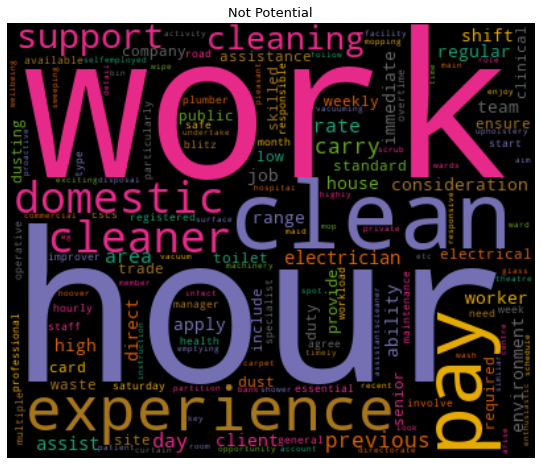

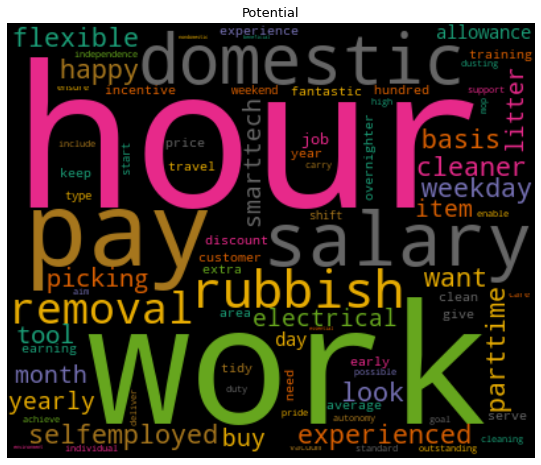

In [19]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
from matplotlib import pyplot as plt

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
train_dtm=train_dtm.transpose()

# Plotting word cloud for each product
for index,summary in enumerate(train_dtm.columns):
  generate_wordcloud(train_dtm[summary].sort_values(ascending=False),summary)

##5. Data Pre-Processing

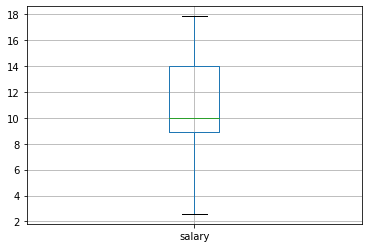

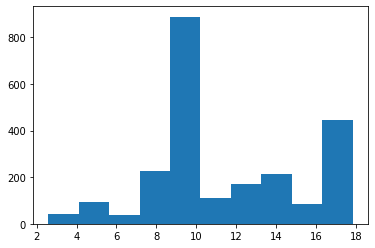

In [20]:
#Explore salary
train.boxplot(column=['salary'])
plt.show()

plt.hist(train.salary)
plt.show()


In [21]:
#Rename
train.rename(columns={'target ': 'target'}, inplace=True)
train.rename(columns={'salary': 'Salary'}, inplace=True)

In [22]:
train['target'].value_counts()

Not Potential    1270
Potential        1047
Name: target, dtype: int64

In [23]:
print(train.columns.tolist())

['Salary', 'summary', 'target', 'clean_summary', 'lemmatized_stopword_summary', 'tokenized_summary']


In [24]:
#One hot encoding the target variable
target_dummies = pd.get_dummies(train.target)
train = pd.concat([train, target_dummies], axis=1)
display(train.head())

,Salary,summary,target,clean_summary,lemmatized_stopword_summary,tokenized_summary,Not Potential,Potential
2115,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,smarttech buy an electrical item and pay it o...,smarttech buy electrical item pay salary ...,"[smarttech, buy, electrical, item, pay, salary...",0,1
1993,10.800000,If you have previous experience as a Cleaner A...,Not Potential,if you have previous experience as a cleaner a...,previous experience cleaner apply immediate co...,"[previous, experience, cleaner, apply, immedia...",1,0
2002,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...,exciting opportunity arise facility directorat...,"[exciting, opportunity, arise, facility, direc...",1,0
293,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...,exciting opportunity arise facility directorat...,"[exciting, opportunity, arise, facility, direc...",1,0
891,17.109375,We are looking for experienced domestic cleane...,Potential,we are looking for experienced domestic cleane...,look experienced domestic cleaner want parttim...,"[look, experienced, domestic, cleaner, want, p...",0,1


In [25]:
train2 = pd.concat([train,token], axis=1)

In [26]:
display(train2)

,Salary,summary,target,clean_summary,lemmatized_stopword_summary,tokenized_summary,Not Potential,Potential,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
2115,9.465144,SmartTech - Buy an electrical item and pay it ...,Potential,smarttech buy an electrical item and pay it o...,smarttech buy electrical item pay salary ...,"[smarttech, buy, electrical, item, pay, salary...",0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.278194
1993,10.800000,If you have previous experience as a Cleaner A...,Not Potential,if you have previous experience as a cleaner a...,previous experience cleaner apply immediate co...,"[previous, experience, cleaner, apply, immedia...",1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373376,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2002,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...,exciting opportunity arise facility directorat...,"[exciting, opportunity, arise, facility, direc...",1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.333386,0.0,0.00000,0.0,0.333386,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
293,7.705128,An exciting opportunity has arisen within the ...,Not Potential,an exciting opportunity has arisen within the ...,exciting opportunity arise facility directorat...,"[exciting, opportunity, arise, facility, direc...",1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.333386,0.0,0.00000,0.0,0.333386,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
891,17.109375,We are looking for experienced domestic cleane...,Potential,we are looking for experienced domestic cleane...,look experienced domestic cleaner want parttim...,"[look, experienced, domestic, cleaner, want, p...",0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.299954,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299655,0.0,0.0,0.0,0.0,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196017,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,7.343750,Rece

In [27]:
#Drop unnecessary columns
train3 = train2.drop(['summary','target','clean_summary','lemmatized_stopword_summary','tokenized_summary'], axis=1) 
display(train3)


,Salary,Not Potential,Potential,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,beneficial,big,bin,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
2115,9.465144,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.278194
1993,10.800000,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373376,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2002,7.705128,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.333386,0.0,0.00000,0.0,0.333386,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
293,7.705128,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.333386,0.0,0.00000,0.0,0.333386,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
891,17.109375,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299655,0.0,0.0,0.0,0.0,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196017,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,7.343750,1,0,0.238467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111831,0.0,0.0,0.000000,0.000000
2220,12.019231,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.304329,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.304329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149155,0.0,0.0,0.303138,0.000000
1821,17.084936,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.299954,0.0,0.0,0.0,0.

In [28]:
#Separate into predictor and target variable
X1 = train3['Salary']
X2 = train3.iloc[:,3:]
X = pd.concat([X1,X2], axis=1)
y = train3.iloc[:, 1:3]

In [29]:
display(X)

,Salary,ability,able,access,accordance,account,achieve,activity,agree,aim,allowance,alongside,animal,annual,apartment,app,applicant,application,apply,appoint,area,arise,assist,assistance,assistant,assistantscleaner,association,autonomy,available,average,bank,base,basis,bed,belong,beneficial,big,bin,blitz,building,...,town,trade,training,travel,trust,type,typical,uk,understand,undertake,upholstery,use,usually,vacuum,vacuuming,varied,vision,visit,vital,wait,want,ward,wards,wash,waste,water,week,weekday,weekend,weekly,weeton,welfare,well,wellbeing,wipe,work,worker,workload,year,yearly
2115,9.465144,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.278194
1993,10.800000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.373376,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.412908,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2002,7.705128,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.333386,0.0,0.00000,0.0,0.333386,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
293,7.705128,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.333386,0.0,0.00000,0.0,0.333386,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
891,17.109375,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299655,0.0,0.0,0.0,0.0,0.0,0.0,0.299954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196017,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,7.343750,0.238467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111831,0.0,0.0,0.000000,0.000000
2220,12.019231,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.304329,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.304329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149155,0.0,0.0,0.303138,0.000000
1821,17.084936,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0

In [30]:
display(y)

,Not Potential,Potential
2115,0,1
1993,1,0
2002,1,0
293,1,0
891,0,1
...,...,...
1266,1,0
2220,1,0
1821,0,1
1047,1,0


In [31]:
#Data Splitting

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=13)

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1621, 353)
(1621, 2)
(696, 353)
(696, 2)


##8. Models Building

In [33]:
#1. Logistic Regression

class_names = ['Potential','Not Potential']

losses = []
auc = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = LogisticRegression(solver='sag', C=10)

    cv_loss = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))

    cv_score = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(X_train, train_target)
    y_pred = classifier.predict(X_test)
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

CV Log_loss score for class Potential is -0.12974710701757133


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

CV Accuracy score for class Potential is 0.9660778727445394


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


CV ROC_AUC score 0.9745474501717071

[[357  20]
 [  4 315]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       377
           1       0.94      0.99      0.96       319

    accuracy                           0.97       696
   macro avg       0.96      0.97      0.97       696
weighted avg       0.97      0.97      0.97       696



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
 

CV Log_loss score for class Not Potential is -0.12974698388046707


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sp

CV Accuracy score for class Not Potential is 0.9660778727445394
CV ROC_AUC score 0.9745474501717071

[[315   4]
 [ 20 357]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       319
           1       0.99      0.95      0.97       377

    accuracy                           0.97       696
   macro avg       0.96      0.97      0.97       696
weighted avg       0.97      0.97      0.97       696

Total average CV Log_loss score is -0.12974704544901922
Total average CV ROC_AUC score is 0.9745474501717071


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [34]:
#2. Support Vector Machine

class_names = ['Potential','Not Potential']

losses = []
auc = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = svm.SVC(kernel='rbf', C=1e9, gamma=1e-07, probability=True) 

    cv_loss = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))

    cv_score = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(X_train, train_target)
    y_pred = classifier.predict(X_test)
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Log_loss score for class Potential is -0.5119893269148185


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Accuracy score for class Potential is 0.9074624881291549


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


CV ROC_AUC score 0.8383043828941571

[[359  18]
 [ 56 263]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       377
           1       0.94      0.82      0.88       319

    accuracy                           0.89       696
   macro avg       0.90      0.89      0.89       696
weighted avg       0.90      0.89      0.89       696



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Log_loss score for class Not Potential is -0.6025323039008582


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Accuracy score for class Not Potential is 0.8173390313390314
CV ROC_AUC score 0.8383043828941569

[[263  56]
 [ 18 359]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       319
           1       0.87      0.95      0.91       377

    accuracy                           0.89       696
   macro avg       0.90      0.89      0.89       696
weighted avg       0.90      0.89      0.89       696

Total average CV Log_loss score is -0.5572608154078383
Total average CV ROC_AUC score is 0.838304382894157


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [35]:
#3. Random Forest 

class_names = ['Potential','Not Potential']

losses = []
auc = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = RandomForestClassifier(n_estimators=100, random_state=0) 

    cv_loss = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))

    cv_score = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(X_train, train_target)
    y_pred = classifier.predict(X_test)
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Log_loss score for class Potential is -0.1746210180624175


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Accuracy score for class Potential is 0.9673105413105413


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


CV ROC_AUC score 0.9790791847866759

[[359  18]
 [  4 315]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       377
           1       0.95      0.99      0.97       319

    accuracy                           0.97       696
   macro avg       0.97      0.97      0.97       696
weighted avg       0.97      0.97      0.97       696



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Log_loss score for class Not Potential is -0.17461953884513928


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Accuracy score for class Not Potential is 0.9673105413105413
CV ROC_AUC score 0.9790791847866759

[[315   4]
 [ 18 359]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       319
           1       0.99      0.95      0.97       377

    accuracy                           0.97       696
   macro avg       0.97      0.97      0.97       696
weighted avg       0.97      0.97      0.97       696

Total average CV Log_loss score is -0.1746202784537784
Total average CV ROC_AUC score is 0.9790791847866759


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [36]:
#4. Gradient Boosting

class_names = ['Potential','Not Potential']

losses = []
auc = []

for class_name in class_names:
    #call the labels one column at a time so we can run the classifier on them
    train_target = y_train[class_name]
    test_target = y_test[class_name]
    classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0) 

    cv_loss = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='neg_log_loss'))
    losses.append(cv_loss)
    print('CV Log_loss score for class {} is {}'.format(class_name, cv_loss))

    cv_score = np.mean(cross_val_score(classifier, X_train, train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(class_name, cv_score))
    
    classifier.fit(X_train, train_target)
    y_pred = classifier.predict(X_test)
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(test_target, y_pred_prob)
    auc.append(auc_score)
    print("CV ROC_AUC score {}\n".format(auc_score))
    
    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

print('Total average CV Log_loss score is {}'.format(np.mean(losses)))
print('Total average CV ROC_AUC score is {}'.format(np.mean(auc)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Log_loss score for class Potential is -0.1211771707795303


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Accuracy score for class Potential is 0.9673086419753087


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


CV ROC_AUC score 0.9791540207711433

[[359  18]
 [  3 316]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       377
           1       0.95      0.99      0.97       319

    accuracy                           0.97       696
   macro avg       0.97      0.97      0.97       696
weighted avg       0.97      0.97      0.97       696



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Log_loss score for class Not Potential is -0.12112331013841897


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse co

CV Accuracy score for class Not Potential is 0.9673086419753087
CV ROC_AUC score 0.9792288567556106

[[316   3]
 [ 18 359]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       319
           1       0.99      0.95      0.97       377

    accuracy                           0.97       696
   macro avg       0.97      0.97      0.97       696
weighted avg       0.97      0.97      0.97       696

Total average CV Log_loss score is -0.12115024045897463
Total average CV ROC_AUC score is 0.9791914387633769


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
